# Train Temporal Fusion Transformer predictor using PyTorch-Forecasting

In [1]:
# top-level requirements: pytorch-forecasting, ipykernel, jupyter, tensorboard, plotly
# install numba for improved speed

Following along with training example provided in docs - https://github.com/jdb78/pytorch-forecasting & https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
# imports for training
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss

## Set up data

In [4]:
# load training dataset from CSV
csv_fname = 'UCam_Building_5'
dataset_dir = os.path.join('data','example') # dataset directory
train_data = pd.read_csv(os.path.join(dataset_dir,'test',f'{csv_fname}.csv'))
val_data = pd.read_csv(os.path.join(dataset_dir,'validate',f'{csv_fname}.csv'))

In [5]:
def reformat_df(df):
    df = df.rename_axis('time_idx').reset_index() # create column of indices to pass as time_idx to TimeSeriesDataSet - we have no missing values
    df['ts_id'] = f'b{5}' # create column with ID of timeseries (use f'b{UCam building ID}')
    for col in ['Month','Hour','Day Type','Daylight Savings Status']:
        df[col] = df[col].astype(str) # convert to strs to use as categoric covariates
    return df

In [6]:
train_data, val_data = [reformat_df(df) for df in [train_data, val_data]]

In [7]:
train_data

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
0,0,12,24,1,0,NaN,NaN,NaN,70.0,0,0,0,0.0,b5
1,1,1,1,2,0,NaN,NaN,NaN,69.3,0,0,0,0.0,b5
2,2,1,2,2,0,NaN,NaN,NaN,69.3,0,0,0,0.0,b5
3,3,1,3,2,0,NaN,NaN,NaN,69.8,0,0,0,0.0,b5
4,4,1,4,2,0,NaN,NaN,NaN,69.4,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,12,19,3,0,NaN,NaN,NaN,65.0,0,0,0,0.0,b5
17516,17516,12,20,3,0,NaN,NaN,NaN,65.3,0,0,0,0.0,b5
17517,17517,12,21,3,0,NaN,NaN,NaN,60.6,0,0,0,0.0,b5
17518,17518,12,22,3,0,NaN,NaN,NaN,57.6,0,0,0,0.0,b5


In [8]:
val_data

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
0,0,12,24,5,0,NaN,NaN,NaN,83.5,0,0,0,0.0,b5
1,1,1,1,6,0,NaN,NaN,NaN,67.1,0,0,0,0.0,b5
2,2,1,2,6,0,NaN,NaN,NaN,67.9,0,0,0,0.0,b5
3,3,1,3,6,0,NaN,NaN,NaN,68.4,0,0,0,0.0,b5
4,4,1,4,6,0,NaN,NaN,NaN,67.2,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,17539,12,19,1,0,NaN,NaN,NaN,71.6,0,0,0,0.0,b5
17540,17540,12,20,1,0,NaN,NaN,NaN,70.1,0,0,0,0.0,b5
17541,17541,12,21,1,0,NaN,NaN,NaN,69.4,0,0,0,0.0,b5
17542,17542,12,22,1,0,NaN,NaN,NaN,69.1,0,0,0,0.0,b5


In [9]:
# construct training dataset
max_encoder_length = 48 # max number of previous instances to use for prediction
max_prediction_length = 24 # max forecasting horizon

training = TimeSeriesDataSet(
    train_data,
    time_idx= 'time_idx',  # column name of time of observation
    target= 'Equipment Electric Power [kWh]',  # column name of target to predict
    group_ids=['ts_id'],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID - ignore for the moment
    #static_categoricals=[ ... ],
    #static_reals=[ ... ],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=['Month','Hour','Day Type','Daylight Savings Status'],
    #time_varying_known_reals=[ ... ],
    #time_varying_unknown_categoricals=[ ... ],
    #time_varying_unknown_reals=[ ... ],
)

In [10]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, val_data)

In [11]:
# convert datasets to dataloaders for training
batch_size = 128
n_workers = 4
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=n_workers)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=n_workers)

## Train model

In [12]:
pl.seed_everything(42)

Global seed set to 42


42

### Tune hyper-parameters

In [13]:
hparam_trainer = pl.Trainer(
    deterministic=True,
    gpus=0,
    gradient_clip_val=0.1, # clipping gradients is a hyperparameter and important to prevent divergance of the gradient for recurrent neural networks
    logger=TensorBoardLogger(save_dir=os.path.join("lightning_logs","TFT-test"), name=f'{csv_fname}')
)


# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=48,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    #log_interval=2,
    # set optimizer
    optimizer='adam',
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=5
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 119.8k


/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/max/Documents/PhD/Research/3 - Annex 37 CityLearn project/Annex_37/.lr_find_243e300f-4323-4203-b01c-41118c1e4dbe.ckpt
Restored all states from the checkpoint file at /Users/max/Documents/PhD/Research/3 - Annex 37 CityLearn project/Annex_37/.lr_find_243e300f-4323-4203-b01c-41118c1e4dbe.ckpt


Suggested learning rate: 0.001


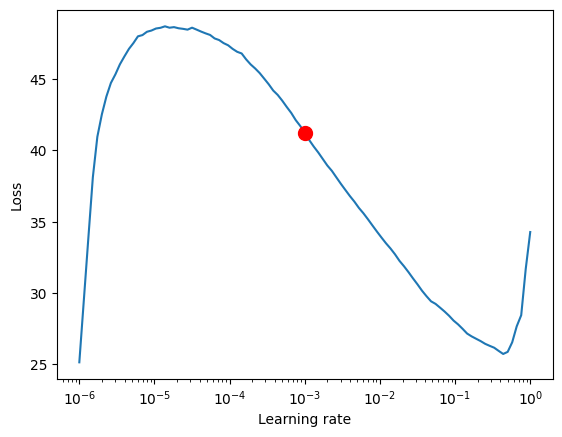

/var/folders/6t/69m7_zyd5_7crwy0sp1s3x100000gn/T/ipykernel_51406/3775189597.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [14]:
# find optimal learning rate
res = hparam_trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

print(f"Suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [15]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [16]:
# This is going to be a hefty hparam optimisation
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

### Perform training

In [17]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    deterministic=True,
    accelerator='cpu',
    max_epochs=100,
    #gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=500,  # batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger(save_dir=os.path.join("lightning_logs","TFT-test"), name=f'{csv_fname}')
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
# define network to train - can I just load this?
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=48,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    #log_interval=2,
    # set optimizer
    optimizer='adam',
    # optimizer parameters
    learning_rate=res.suggestion(),
    reduce_on_plateau_patience=5
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 119.8k


/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [19]:
# fit the model on the data 
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    #ckpt_path='best' # use of re-training after load
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 325   
3  | prescalers                         | ModuleDict                      | 0     
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 936   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 936   
7  | static_context_variable_selection  | GatedResidualNetwork            | 9.5 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 9.5 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 9.5 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Evaluate trained model

In [20]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

# os.path.join('lightning_logs','TFT-test', 'UCam_Building_5','version_3','checkpoints','epoch=18-step=2584.ckpt')
tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/TFT-test/UCam_Building_5/version_3/checkpoints/epoch=18-step=2584.ckpt


In [21]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
print((actuals - predictions).abs().mean())
print(val_data['Equipment Electric Power [kWh]'].abs().mean())

tensor(12.1847)
129.83198814409485


In [22]:
print(np.array(predictions[245]))

[110.67912  111.76519  117.27004  181.918    208.37369  218.7532
 220.94153  220.94788  215.77792  214.45074  213.62408  209.11026
 200.11441  182.23985  155.71082  137.03325   86.60782   69.42182
  69.16123   68.7106    69.07926   70.5229    76.369865 101.3596  ]


In [23]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)
print(tft.loss.compute())

tensor(7.8849)


In [24]:
print(tft.loss)

QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])


In [25]:
print(raw_predictions.keys())
print(x.keys())

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')
dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


In [26]:
print(raw_predictions['prediction'].shape)
print(x['decoder_target'].shape)
print(x['encoder_target'].shape)

torch.Size([17473, 24, 7])
torch.Size([17473, 24])
torch.Size([17473, 48])


In [27]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

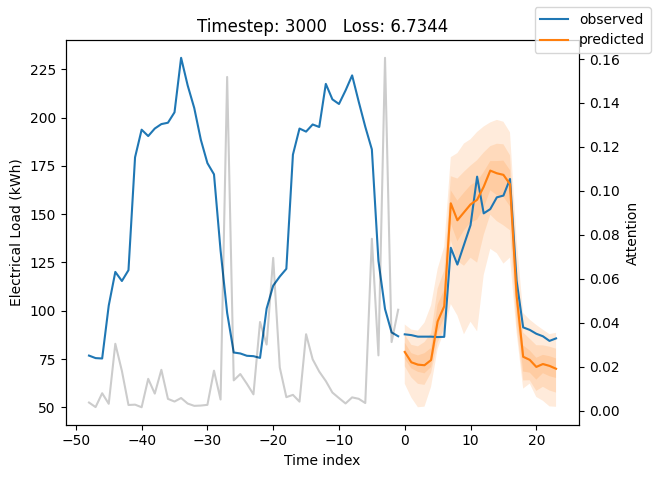

In [28]:
fig, main_ax = plt.subplots()
idx = 3000
fig = tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True, ax=main_ax)
axs = fig.get_axes()
axs[0].set_ylabel('Electrical Load (kWh)')
prediction_loss = float(axs[0].get_title().split(' ')[1])
axs[0].set_title(f'Timestep: {idx}   Loss: {round(prediction_loss,4)}')
plt.show()

In [29]:
# kWh_max = 300
# start = 1000

# fig, main_ax = plt.subplots()
# alt_ax = main_ax.twinx()

# def animate(i,offset=start):
#     idx = i + offset

#     main_ax.clear()
#     alt_ax.clear()

#     main_ax.set_ylim(0,kWh_max)
#     alt_ax.set_ylim(0,np.max(np.array(raw_predictions['encoder_attention'])))
#     main_ax.set_ylabel('Electrical Load (kWh)')

#     # plot attention manually - taken from source code, https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/models/temporal_fusion_transformer.html#TemporalFusionTransformer.plot_prediction
#     encoder_length = x["encoder_lengths"][0]
#     interpretation = tft.interpret_output(raw_predictions.iget(slice(idx, idx + 1)))
#     alt_ax.plot([-1*i for i in reversed(range(1,encoder_length+1))],interpretation['attention'][0,-encoder_length:], c='k', alpha=0.2)

#     tft.plot_prediction(x, raw_predictions, idx=idx, plot_attention=False, add_loss_to_title=True, ax=main_ax)

#     prediction_loss = float(main_ax.get_title().split(' ')[1])
#     main_ax.set_title(f'Timestep: {idx}' + ' '*4 + 'Loss: ' + f'{prediction_loss:.3f}'.rjust(6), loc='center')

#     return *main_ax.get_lines(), *alt_ax.get_lines()

# n_frames = 24*14
# anim = animation.FuncAnimation(fig, animate, frames=n_frames, interval=200, blit=True)
# writer = animation.writers['ffmpeg']()
# anim.save('predict_anim.mp4', writer=writer, dpi=100)


In [ ]:
import plotly.graph_objects as go
from plotly.offline import plot as ply_plot
from tqdm.notebook import tqdm

duration = 24*7*12
idx_start = 0
idx_end = idx_start+duration

max_encoder_length = 48
max_prediction_length = 24
kWh_max = 300
max_attention = 0.4
transition_duration = 0
frame_duration = 100

prediction_losses = []

# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [-1*(max_encoder_length+1), max_prediction_length+2], "showgrid":True}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": frame_duration, "redraw": False},
                                "fromcurrent": True,
                                "transition": {"duration": transition_duration, "easing": "linear"}
                                }],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}
                                    }],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 12},
        "prefix": "Timestep: ",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": transition_duration, "easing": "linear"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

# make frames
for j,idx in tqdm(enumerate(range(idx_start,idx_end+1))):

    frame = {"data": [], "name": str(idx)}

    # get encoder length, compute attention
    encoder_length = x["encoder_lengths"][0]
    interpretation = tft.interpret_output(raw_predictions.iget(slice(idx, idx + 1)))

    # outrageously hacky way of computing prediction loss
    fig, dummy_ax = plt.subplots()
    tft.plot_prediction(x, raw_predictions, idx=idx, plot_attention=False, add_loss_to_title=True, ax=dummy_ax)
    prediction_loss = float(dummy_ax.get_title().split(' ')[1])
    plt.close(fig)
    del fig, dummy_ax
    prediction_losses.append(prediction_loss)

    # construct plots for each frame
    plot_data = [
        go.Bar( # prediction loss bar chart
            x=[max_prediction_length+1],
            y=[prediction_loss],
            width=1,
            marker=dict(color="rgba(244, 50, 12, 1)"),
            name="Loss",
            yaxis='y2',
        ),

        go.Scatter( # p95 area fill
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,0],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.1)", width=0),
            name="p95",
            showlegend=False
        ),
        go.Scatter(
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,6],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.1)", width=0),
            name="p95",
            fill='tonexty'
        ),
        go.Scatter( # p80 area fill
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,1],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.2)", width=0),
            name="p80",
            showlegend=False
        ),
        go.Scatter(
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,5],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.2)", width=0),
            name="p80",
            fill='tonexty'
        ),
        go.Scatter( # p50 area fill
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,2],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.4)", width=0),
            name="p50",
            showlegend=False
        ),
        go.Scatter(
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,4],
            mode="lines",
            line=dict(color="rgba(249, 115, 6, 0.4)", width=0),
            name="p50",
            fill='tonexty'
        ),

        go.Scatter( # encoder attention
            x=[-1*i for i in reversed(range(1,encoder_length+1))],
            y=interpretation['attention'][0,-encoder_length:],
            mode="lines",
            line=dict(color="rgba(63, 155, 11, 0.5)", width=2),
            yaxis='y3',
            name="Attention"
        ),
        go.Scatter( # decoder target
            x=list(range(max_prediction_length)),
            y=x['decoder_target'][idx],
            mode="lines",
            line=dict(color="rgba(1, 21, 62, 1)", width=2),
            legendgroup="target",
            name="Target"
        ),
        go.Scatter( # encoder target
            x=[-1*i for i in reversed(range(1,encoder_length+1))],
            y=x['encoder_target'][idx],
            mode="lines",
            line=dict(color="rgba(1, 21, 62, 1)", width=2),
            legendgroup="target",
            showlegend=False,
            name="Target"
        ),

        go.Scatter( # mean prediction
            x=list(range(max_prediction_length)),
            y=raw_predictions['prediction'][idx,:,3],
            mode="lines",
            line=dict(color="rgba(117,187,253, 1)", width=2),
            name="Mean prediction"
        ),
    ]

    if j == 0: # set initial data to plot
        fig_dict["data"] = plot_data

    frame = go.Frame(
        data=plot_data,
        name=str(idx),
    )

    fig_dict["frames"].append(frame)

    slider_step = {"args": [
        [idx],
        {"frame": {"duration": transition_duration, "redraw": False},
            "mode": "immediate",
            "transition": {"duration": transition_duration},
        }
        ],
        "label": idx,
        "method": "animate"
    }
    sliders_dict["steps"].append(slider_step)

fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.update_layout(
    yaxis=dict(
        title="Electrical Load (kWh)",
        range=[0,kWh_max],
        side="left"
    ),
    yaxis2=dict(
        title="Prediction Loss",
        range=[0,2.5*np.mean(prediction_losses)],
        anchor="x",
        overlaying="y",
        side="right",
        tickmode="sync"
    ),
    yaxis3=dict(
        title="Attention",
        range=[0,max_attention],
        anchor="free",
        overlaying="y",
        #side="left",
        showgrid=False,
        autoshift=True
    ),
    legend=dict(
        traceorder="reversed",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

ply_plot(
    fig,
    filename='temp.html',
    auto_open=False,
    auto_play=False
)

fig.show()

Try predicting on explicitly passed data as we will need to do for the forecasting

In [31]:
data_slice = val_data.iloc[1242:1314]
data_slice.iloc[-24:,data_slice.columns.get_loc('Equipment Electric Power [kWh]')] = 0
explicit_dataset = TimeSeriesDataSet.from_dataset(training, data_slice)

Note: because this model has known covariates over the prediction horizon, the explicit dataset we pass needs to have a length of `max_encoder_length`+`max_prediction_length`, but the target series values over the prediction horizons are (obviously) not used, so any values can be placed here (e.g. set to zero)

In [32]:
data_slice

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
1242,1242,2,18,1,0,NaN,NaN,NaN,73.9,0,0,0,0.0,b5
1243,1243,2,19,1,0,NaN,NaN,NaN,75.8,0,0,0,0.0,b5
1244,1244,2,20,1,0,NaN,NaN,NaN,74.1,0,0,0,0.0,b5
1245,1245,2,21,1,0,NaN,NaN,NaN,71.5,0,0,0,0.0,b5
1246,1246,2,22,1,0,NaN,NaN,NaN,71.8,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1309,2,13,4,0,NaN,NaN,NaN,0.0,0,0,0,689.0,b5
1310,1310,2,14,4,0,NaN,NaN,NaN,0.0,0,0,0,623.0,b5
1311,1311,2,15,4,0,NaN,NaN,NaN,0.0,0,0,0,505.0,b5
1312,1312,2,16,4,0,NaN,NaN,NaN,0.0,0,0,0,217.0,b5


In [33]:
slice_predictions = tft.predict(explicit_dataset, mode='prediction')

In [34]:
print(slice_predictions)

tensor([[205.5509, 184.5760, 167.6945,  87.0219,  60.4790,  58.5570,  58.6357,
          57.1208,  60.3246,  65.1739, 102.9172, 114.5882, 113.4695, 122.3041,
         190.3150, 216.3943, 227.3048, 230.6091, 232.9309, 231.7788, 230.2433,
         228.6533, 223.3952, 212.9826]])
